<a href="https://colab.research.google.com/github/ankanghosh/housing-price-prediction/blob/main/HousingPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


# Fetch and read the data

In [ ]:
# Import the dataset from Google Drive.
from google.colab import drive
drive.mount('/content/drive')



data_path = '/content/drive/MyDrive/Datasets/Kaggle/housing_price_dataset.csv'
raw_dataset = pds.read_csv(data_path,
                         na_values='?', comment='\t',
                         sep=',', skipinitialspace=True)


Mounted at /content/drive


In [ ]:
dataset = raw_dataset.copy()
dataset.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


# Clean the data

In [ ]:
# Check if there are unknown values.
print (dataset.isna().sum())
print(dataset.dtypes)

# Convert the categorical values in Neighborhood and numeric by one-hot encoding the values across columns for each data item.
dataset['Neighborhood'] = dataset['Neighborhood'].map({'Rural': 'Rural', 'Urban': 'Urban', 'Suburb': 'Suburb'})
dataset = pds.get_dummies(dataset, columns=['Neighborhood'])
dataset.tail()

print(dataset.shape)
print(dataset.info())

# Convert the Object type numerical columns to float for plotting and visualization.
numerical_columns = ['SquareFeet', 'Bedrooms', 'Bathrooms', 'YearBuilt', 'Price']

for col in numerical_columns:
  dataset[col] = dataset[col].astype(float)
  # Check for infinity values in each column.
  print(np.isinf(dataset[col]).sum())
dataset.head()
print(dataset.dtypes)

SquareFeet      0
Bedrooms        0
Bathrooms       0
Neighborhood    0
YearBuilt       0
Price           0
dtype: int64
SquareFeet        int64
Bedrooms          int64
Bathrooms         int64
Neighborhood     object
YearBuilt         int64
Price           float64
dtype: object
(50000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SquareFeet           50000 non-null  int64  
 1   Bedrooms             50000 non-null  int64  
 2   Bathrooms            50000 non-null  int64  
 3   YearBuilt            50000 non-null  int64  
 4   Price                50000 non-null  float64
 5   Neighborhood_Rural   50000 non-null  bool   
 6   Neighborhood_Suburb  50000 non-null  bool   
 7   Neighborhood_Urban   50000 non-null  bool   
dtypes: bool(3), float64(1), int64(4)
memory usage: 2.1 MB
None
0
0
0
0
0
SquareFeet             float

# Split the data for training

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Investigate the data.
train_dataset.head()
print(train_dataset.dtypes)
train_dataset.describe().transpose()

SquareFeet             float64
Bedrooms               float64
Bathrooms              float64
YearBuilt              float64
Price                  float64
Neighborhood_Rural        bool
Neighborhood_Suburb       bool
Neighborhood_Urban        bool
dtype: object


,count,mean,std,min,25%,50%,75%,max
SquareFeet,40000.0,2007.332850,575.304361,1000.000000,1514.000000,2010.00000,2505.000000,2999.000000
Bedrooms,40000.0,3.504350,1.117592,2.000000,3.000000,4.00000,5.000000,5.000000
Bathrooms,40000.0,1.997200,0.814898,1.000000,1.000000,2.00000,3.000000,3.000000
YearBuilt,40000.0,1985.411475,20.737093,1950.000000,1967.000000,1985.00000,2003.000000,2021.000000
Price,40000.0,225056.351003,76177.307953,-36588.165397,169984.236737,225214.86162,279857.271428,492195.259972


# Inspect the data

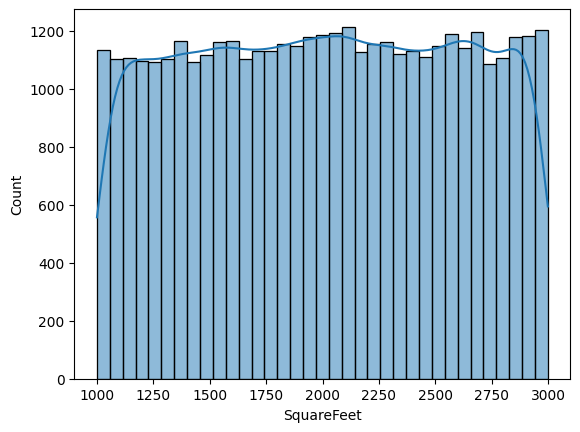

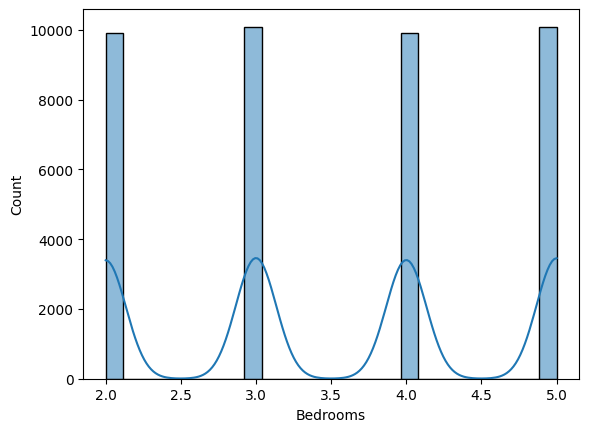

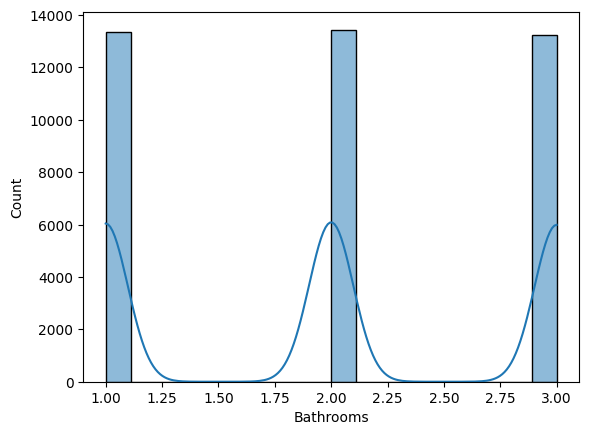

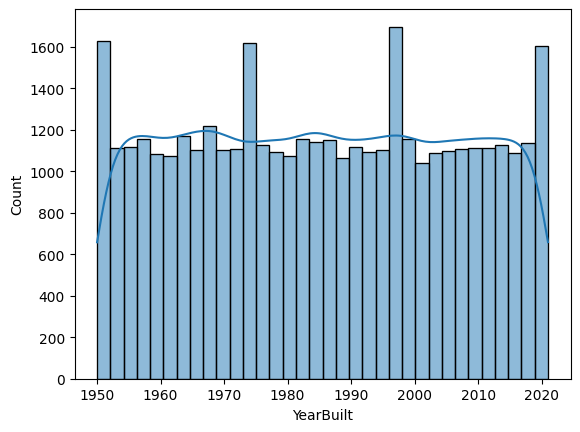

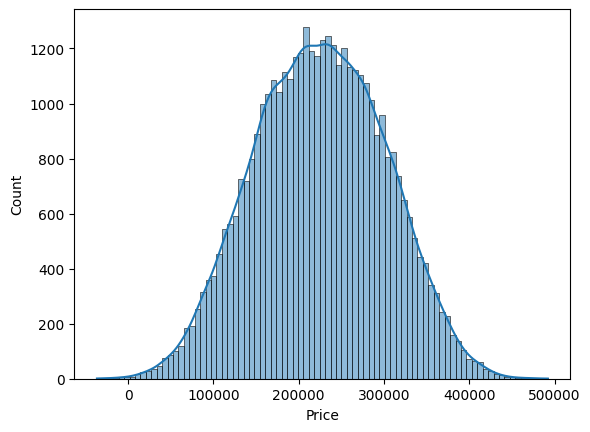

In [ ]:
for col in numerical_columns:
  sns.histplot(data=train_dataset, x = col, kde=True)
  plt.show()

# Separate out the labels from the features


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

Convert the features and labels into float so that conversions between NumPy arrays and Tensors are seamless.

In [ ]:
train_features_float = train_features.astype('float32')
train_labels_float = train_features_float.pop('Price')
test_features_float = test_features.astype('float32')
test_labels_float = test_features_float.pop('Price')

# Normalization

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features_float))
print(normalizer.mean.numpy())

first = np.array(train_features_float[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[2007.33     3.504    1.997 1985.412    0.332    0.336    0.332]]
First example: [[2511.    3.    2. 1951.    1.    0.    0.]]

Normalized: [[ 0.88 -0.45  0.   -1.66  1.42 -0.71 -0.7 ]]


# Regression model

We will implement Regression using a Deep Neural Network (DNN) with multiple inputs.

In [ ]:
dnn_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(units=1)
])

In [ ]:
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

In [ ]:
# Investigate the model.
dnn_model.summary()
dnn_model.layers[1].kernel
dnn_model.predict(train_features_float[:10])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 202ms/step


array([[ 0.346],
       [ 0.338],
       [ 0.177],
       [ 0.181],
       [-0.014],
       [-0.022],
       [ 0.289],
       [ 0.057],
       [ 0.242],
       [ 0.151]], dtype=float32)

# Train the model

In [ ]:
%%time
history = dnn_model.fit(
    train_features_float,
    train_labels_float,
    epochs=20,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 40.9 s, sys: 2 s, total: 42.9 s
Wall time: 37 s


In [ ]:
# Function to plot the training loss.
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.grid(True)
  plt.show()

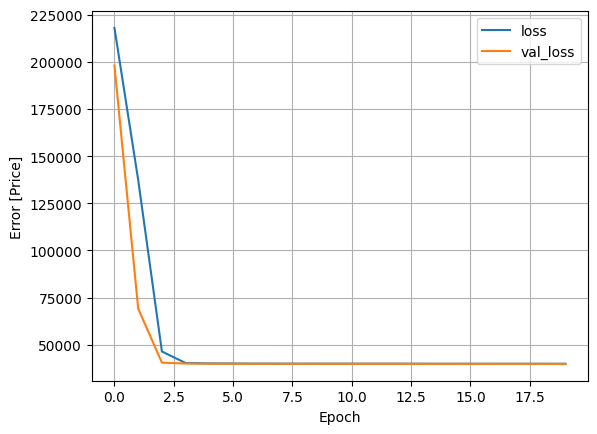

In [ ]:
plot_loss(history)

# Evaluate the model

To assess how well the trained model performs on unseen data, we evaluate it using the test set and store the results.

In [ ]:
# Collect the test results.
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    test_features_float, test_labels_float, verbose=0)

In [ ]:
# Check the Mean Absolute Error of the DNN model.
pds.DataFrame(test_results, index=['Mean absolute error [Price]']).T

,Mean absolute error [Price]
dnn_model,40376.863281


Make predictions.

313/313 [==============================] - 0s 1ms/step


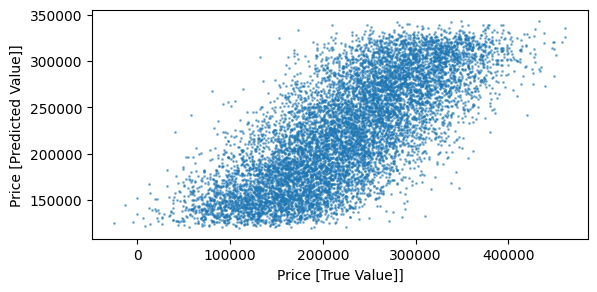

In [ ]:
test_predictions = dnn_model.predict(test_features_float).flatten()

# Plot the predictions.
a = plt.axes(aspect='equal')
plt.scatter(test_labels_float, test_predictions, s=1, alpha=0.5)
plt.xlabel('Price [True Value]]')
plt.ylabel('Price [Predicted Value]]')
plt.show()

Investigate the error distribution.

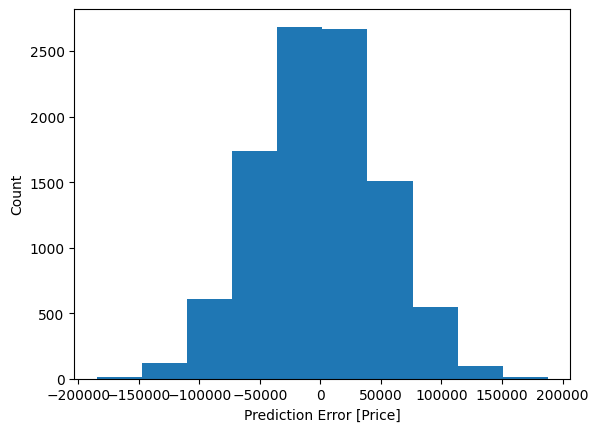

In [ ]:
error = test_predictions - test_labels_float
plt.hist(error)
plt.xlabel('Prediction Error [Price]')
plt.ylabel('Count')
plt.show()